In [84]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import impute
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

### Класс для препроцессинга данных

In [85]:
class DataPreprocessing:
    '''
    Класс для предобработки данных перед загрузкой в модель ML
    '''
    def __init__(self):
        self.train_data = None
        self.qualitative_vars = None
        self.quantitative_vars = None
        
        
    def read_data(self, file):
        '''
        Функция, предназначенная для загрузки данных 
        '''
        self.file = file
        self.train_data = pd.read_csv(self.file)
        
    def missing_data_clear(self, missed_data):
        '''
        Функция обработки отсутствующих данных
        missed_data - словарь, который включает в себя данные по типу {'название колонки': 'действие'}
        Действия могут иметь следующие метки - 
        0 - удалить колонку, если в ней пропущенно слишком много значений
        1 - заменить пропущенные значения на медиану
        '''
        self.missed_data = missed_data
        if self.train_data is None:
            print('Данные не загружены')
        else:
            for key in self.missed_data.keys():
                if self.missed_data[key] == 0:
                    self.train_data = self.train_data.drop(labels=key, axis=1)
                if self.missed_data[key] == 1:
                    imp_median = impute.SimpleImputer(strategy='median')
                    ls = np.array(self.train_data[key]).reshape(-1,1)
                    imp_median.fit(ls)
                    ls_imputed = imp_median.transform(ls)
                    self.train_data[key] = pd.Series(ls_imputed.T[0])
                    
    def group_variables(self):
        '''
        Функция, которая группирует качественные и количественные переменные в отдельные датафреймы. 
        На выходе получим два датасета qualitative_vars и quantitative_vars
        Входная переменная qualitative представляет из себя список из качественных переменных
        '''
        self.qualitative = qualitative
        for item in self.qualitative:
            self.train_data[item] = self.train_data[item].astype('str')
        
        #создадим список количественных фич, по которым будем отбрасывать выбросы
        self.quantitative = self.train_data.select_dtypes(include='float64').columns.to_list() + \
        self.train_data.select_dtypes(include='int64').columns.to_list()
        
        self.qualitative_vars = pd.DataFrame(self.train_data[self.train_data.select_dtypes(include='object').
                                                             columns.to_list()])
        
        self.quantitative_vars = pd.DataFrame(self.train_data[self.train_data.select_dtypes(include='int64').
                                                              columns.to_list()])
        self.quantitative_vars[self.train_data.select_dtypes(include='float64').columns.to_list()] = pd.DataFrame(
    self.train_data[self.train_data.select_dtypes(include='float64').columns.to_list()])
        
    def drop_outliers(self, qualitative):
        
        self.qualitative = qualitative
        for item in self.qualitative:
            self.train_data[item] = self.train_data[item].astype('str')
        
        #создадим список количественных фич, по которым будем отбрасывать выбросы
        self.quantitative = self.train_data.select_dtypes(include='float64').columns.to_list() + \
        self.train_data.select_dtypes(include='int64').columns.to_list()
        
        for feature in self.quantitative:
            stat = self.train_data[feature].describe()
            Q1 = stat[4]
            Q3 = stat[6]
            t1 = Q1 - 1.5*(Q3-Q1)
            t2 = Q3 + 1.5*(Q3-Q1)
            more_t2 = list((self.train_data[feature][self.train_data[feature] > t2]).index)
            less_t1 = list((self.train_data[feature][self.train_data[feature] < t1]).index)
            outliers_indexes = more_t2 + less_t1
            self.train_data = self.train_data.drop(labels=outliers_indexes)
            

### Основной блок обработки данных

Загрузим данные

In [86]:
dp = DataPreprocessing()
dp.read_data('train.csv')

Посмотрим на данные

<AxesSubplot:>

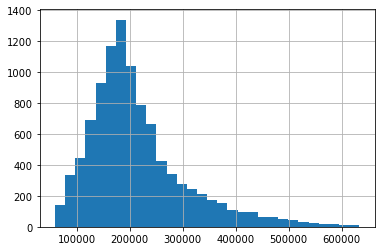

In [87]:
dp.train_data.Price.hist(bins=30)

In [88]:
dp.train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Переменные типа *object* относятся к категориальным. Посмотрим на остальные переменные, может быть среди них есть те, что имеют числовой тип, но к таковым не относятся? Это переменные Id, DistrictId. 

In [89]:
dp.train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [90]:
#переменная содержит список имен фич категориального типа
qualitative = ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [91]:
#избавимся от пропусков. Колонку Healthcare_1 удалим, поскольку в ней почти половины данных нет.
#в колонке LifeSquare заменим пропуски медианным значением
dp.missing_data_clear({'Healthcare_1':0, 'LifeSquare':1})

In [92]:
#удалим выбросы в количественных переменных
dp.drop_outliers(qualitative)

In [93]:
#сгруппируем переменные на категориальные и количественные
dp.group_variables()

In [94]:
dp.qualitative_vars

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B
5,12915,59,B,B,B
...,...,...,...,...,...
9995,77,32,B,B,B
9996,6159,18,B,B,A
9997,5123,27,B,B,A
9998,5400,75,B,A,B


In [95]:
#проведем кодирование категориальных признаков
ord_enc = OrdinalEncoder()
dp.qualitative_vars = pd.DataFrame(ord_enc.fit_transform(dp.qualitative_vars), columns=dp.qualitative_vars.columns)

In [96]:
Y = dp.quantitative_vars.Price

In [97]:
dp.quantitative_vars = dp.quantitative_vars.drop(labels='Price', axis=1)

In [98]:
#проведем стандартизацию количественных переменных
scaler = StandardScaler()
dp.quantitative_vars = pd.DataFrame(scaler.fit_transform(dp.quantitative_vars), columns=dp.quantitative_vars.columns)

In [99]:
X = pd.concat([dp.qualitative_vars, dp.quantitative_vars], axis=1)

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [101]:
def prediction (X_train, X_test, Y_train, Y_test, model_class):
    model = model_class(random_state = 42)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return r2(Y_test, Y_pred)

In [102]:
prediction(X_train, X_test, Y_train, Y_test, RandomForestRegressor)

0.6604137556966825